In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moment
from scipy.stats import kurtosis

It is assumed that the log price p=ln⁡(P) follows a Brownian motion with zero drift and diffusion σ
One day is used as a unit of time meaning the diffusion σ coincides with the daily standard deviation of returns.  
The daily return c is a random variable c~N(0,$σ^2$).  
The goal is to estimate the unobservable volatility $σ^2$ from observed variables c, h, and l.

__1.   Volatility Estimators__

__1.1   Simple Estimator__  

$\hat{σ_{s}^2} = c^2$  

This unbiased estimator of $σ^2$ is rather very noisy and several better estimators which factor in high and low prices have been proposed.

In [29]:
def simple_var(h, l, c):
    return c**2

__1.2   Parkinson Estimator__   
  
$\hat{σ_{p}^2} = \frac{(h-l)^2}{4ln2}$

In [30]:
def parkinson_var(h, l, c):
    return (h - l)**2 / (4 * np.log(2))

__1.3   Garman and Klass Estimator__ 
 
$\hat{σ_{GK}^2} = 0.511(h-l)^2 - 0.019(c(h+l)-2hl)-0.383c^2$ 

Given the cross product term is very small, they recommend dropping it and using the more practical estimator:  
  
$\hat{σ_{GK}^2} = 0.5(h-l)^2 - (2ln2-1)c^2$  

This estimator can be seen as the optimal combination (minimum variance) of the simple and parkinson estimator

In [31]:
def garman_klass_var(h, l, c):
    return 0.5 * (h - l)**2 - (2 * np.log(2) - 1) * c**2

__1.4   Meilijson Estimator__  

This estimator is outside the class of analytical estimators and has a smaller variance than the Garman-Klass estimator.

$\hat{σ_{M}^2} = 0.27352σ_{1}^2 + 0.160358σ_{s}^2 + 0.365212σ_{3}^2 + 0.200910σ_{4}^2$  
where  
$σ_{1}^2 = 2[(h^{'}-c^{'})^2 + {l^{'}}^{2}]$  
$σ_{3}^2 = 2(h^{'}-c^{'}-l^{'})c^{'}$  
$σ_{4}^2 = \frac{(h^{'}-c^{'})l^{'}}{2ln2-1.25}$  
$c^{'}=c, h^{'}=h, l^{'}=l if c > 0$  
$c^{'}=|c|$  
$h^{'} = \begin{cases} h & \text{if } c > 0 \\ -l & \text{if } c < 0 \end{cases}$  
$l^{'} = \begin{cases} l & \text{if } c > 0 \\ -h & \text{if } c < 0 \end{cases}$


In [41]:
def meilijson_var(h, l, c):
    c1 = abs(c)
    h1 = np.where(c < 0.0, -l, h)
    l1 = np.where(c < 0.0, -h, l)
    var1 = 2 * ((h1 - c1)**2 + l1**2)
    var_s = simple_var(h, l, c)
    var3 = 2 * (h1 - c1 - l1) * c1
    var4 = ((c1 - h1) * l1) / (2 * np.log(2) - 1.25)
    var_m = 0.27352 * var1 + 0.160358 * var_s + 0.365212 * var3 + 0.200910 * var4
    return var_m

__1.5   Rogers and Satchell Estimator__  

This estimator allows for arbitrary drift and is given as:  

$\hat{σ_{RS}^2} = h(h-c)+l(l-c)$

In [33]:
def rogers_satchell_var(h, l, c):
    return h * (h-c) + l * (l-c)

<br>

__2.   Bias in σ__

The estimators introduced are all unbiased estimators of $σ^2$. Consequently, the square root of these estimators are all biased estimators of σ.  
In many cases we are interested in σ and not $σ^2$, however, it is very common to use $\sqrt{\hat{σ^2}}$ to estimate σ.  
It is therefore important to understand the magnitude of the error introduced by doing so.

To evaluate the bias introduced by using $\sqrt{\hat{σ^2}}$ instead of $\hat{σ}$, we want to find the constant c such that:
$\hat{σ}=c\sqrt{\hat{σ^2}}$
To achieve this we'll run N simulations with each simulation representing a trading day such that the log price follows a brownian motion with zero drift and daily diffusion σ=1. The continuous brownian motion is approximated by n discrete intraday returns drawn from $N(0, 1/\sqrt{n})$


In [49]:
N = 10000
n = 100000

np.random.seed(1)
St = np.empty((N, n + 1))
St[:, 0] = 0.
St[:, 1:] = np.random.normal(scale=np.sqrt(1/n), size=(N,n))
St = np.cumsum(St, axis=1)

c = St[:,-1]                # open-to-close return
h = np.max(St, axis=1)      # open-to-high return
l = np.min(St, axis=1)      # open-to-low return

var_s = simple_var(h, l, c)
var_pk = parkinson_var(h, l, c)
var_gk = garman_klass_var(h, l, c)
var_m = meilijson_var(h, l, c)
var_rs = rogers_satchell_var(h, l, c)


c_s = 1.0 / np.sqrt(var_s).mean()
c_pk = 1.0 / np.sqrt(var_pk).mean()
c_gk = 1.0 / np.sqrt(var_gk).mean()
c_m = 1.0 / np.sqrt(var_m).mean()
c_rs = 1.0 / np.sqrt(var_rs).mean()


print(f"The bias of the Simple estimator is approximately {c_s-1:.2%}.")
print(f"The bias of the Parkinson estimator is approximately {c_pk-1:.2%}.")
print(f"The bias of the Garma-Klass estimator is approximately {c_gk-1:.2%}.")
print(f"The bias of the Meilijson estimator is approximately {c_m-1:.2%}.")
print(f"The bias of the Rogers-Satchell estimator is approximately {c_rs-1:.2%}.")





The bias of the Simple estimator is approximately 25.62%.
The bias of the Parkinson estimator is approximately 4.84%.
The bias of the Garma-Klass estimator is approximately 3.67%.
The bias of the Meilijson estimator is approximately 3.63%.
The bias of the Rogers-Satchell estimator is approximately 4.58%.


The square root of the simple estimator is a very biased estimator of standard deviation (~26% bias) while the range-based estimators have smaller bias (3%-5%)

__2.1   Distributional properties__

We'll examine the distributions of $\hat{σ^2}$, $\sqrt{\hat{σ^2}}$ and $\ln{\hat{σ^2}}$ because they are the quantities modeled by volatility models.  
Most GARCH models try to capture the time evolution of $σ^2$, EGARCH and stochastic volatility models are based on the time evolution of $\ln{σ^2}$  
and some GARCH models model the time evolution of $σ$

<br>

__2.1.1   Distributional properties of $\hat{σ^2}$ estimators__

[0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0]

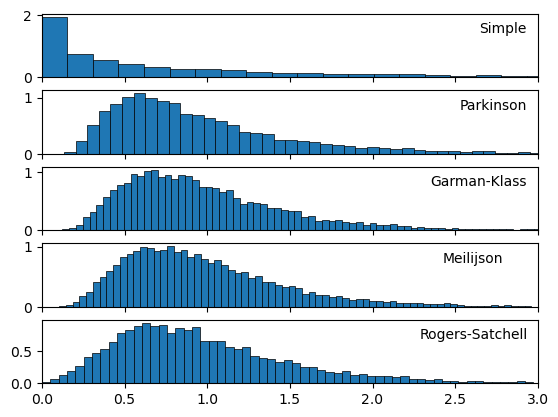

In [56]:
fig, ax = plt.subplots(5, sharex=True)
ax1, ax2, ax3, ax4, ax5 = ax

ax1.text(.93,.7, 'Simple', horizontalalignment='center', transform=ax1.transAxes);
ax1.hist(var_s, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax2.text(.91,.7, 'Parkinson', horizontalalignment='center', transform=ax2.transAxes);
ax2.hist(var_pk, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax3.text(.88,.7, 'Garman-Klass', horizontalalignment='center', transform=ax3.transAxes);
ax3.hist(var_gk, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax4.text(.87,.7, 'Meilijson', horizontalalignment='center', transform=ax4.transAxes);
ax4.hist(var_m, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax5.text(.87,.7, 'Rogers-Satchell', horizontalalignment='center', transform=ax5.transAxes);
ax5.hist(var_rs, density=True, bins=100, edgecolor='black', linewidth=0.5);

plt.setp(ax, xlim=(0.0, 3.0))

The estimators are all unbiased and therefore have the same mean.  
While the density for range-based estimators are approximately lognormal, the distribution of squared returns, which is a $X^2$ distribution with one degree of freedom, is very dispersed and reaches maximum at zero.
Therefore, for most puposes, the distributional properties of range-based estimators make them more attractive.

<br>

__2.1.2   Distributional properties of $\sqrt{\hat{σ^2}}$ estimators__

[0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 3.0]

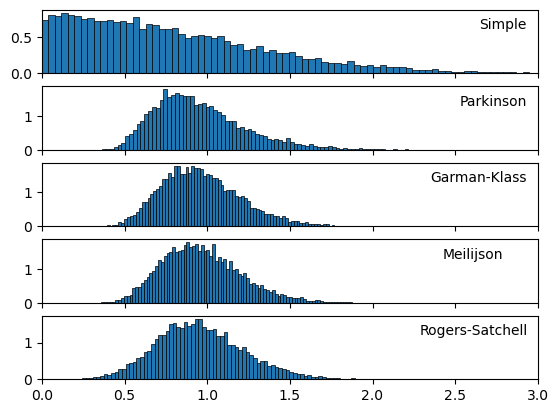

In [58]:
fig, ax = plt.subplots(5, sharex=True)
ax1, ax2, ax3, ax4, ax5 = ax

ax1.text(.93,.7, 'Simple', horizontalalignment='center', transform=ax1.transAxes);
ax1.hist(var_s**0.5, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax2.text(.91,.7, 'Parkinson', horizontalalignment='center', transform=ax2.transAxes);
ax2.hist(var_pk**0.5, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax3.text(.88,.7, 'Garman-Klass', horizontalalignment='center', transform=ax3.transAxes);
ax3.hist(var_gk**0.5, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax4.text(.87,.7, 'Meilijson', horizontalalignment='center', transform=ax4.transAxes);
ax4.hist(var_m**0.5, density=True, bins=100, edgecolor='black', linewidth=0.5);

ax5.text(.87,.7, 'Rogers-Satchell', horizontalalignment='center', transform=ax5.transAxes);
ax5.hist(var_rs**0.5, density=True, bins=100, edgecolor='black', linewidth=0.5);

plt.setp(ax, xlim=(0.0, 3.0))

The distributions of $\sqrt{\hat{σ^2}}$ estimators have less weight on the tails than those of $\hat{σ^2}$ estimators.  
This is due to the square root function which transorms small values (< 1) into larger values (closer to 1) and transforms large values (> 1) into smaller values (values closer to 1). The ideal estimator should mean close to 1 (true value) and standard deviation should be as small as possible.

In [77]:
df = pd.DataFrame(columns=['Mean', 'Std', 'Skewness', 'Kurtosis'])

sigma_s = var_s**0.5
sigma_pk = var_pk**0.5
sigma_gk = var_gk**0.5
sigma_m = var_m**0.5
sigma_rs = var_rs**0.5

df.loc['Simple'] = [sigma_s.mean(), sigma_s.std(), moment(sigma_s, 3)/sigma_s.std()**3, kurtosis(sigma_s, fisher=False)]
df.loc['Park'] = [sigma_pk.mean(), sigma_pk.std(), moment(sigma_pk, 3)/sigma_pk.std()**3, kurtosis(sigma_pk, fisher=False)]
df.loc['GK'] = [sigma_gk.mean(), sigma_gk.std(), moment(sigma_gk, 3)/sigma_gk.std()**3, kurtosis(sigma_gk, fisher=False)]
df.loc['M'] = [sigma_m.mean(), sigma_m.std(), moment(sigma_m, 3)/sigma_m.std()**3, kurtosis(sigma_m, fisher=False)]
df.loc['RS'] = [sigma_rs.mean(), sigma_rs.std(), moment(sigma_rs, 3)/sigma_rs.std()**3, kurtosis(sigma_rs, fisher=False)]

print(df)

            Mean       Std  Skewness  Kurtosis
Simple  0.796030  0.596625  1.003859  3.918998
Park    0.953838  0.281517  0.979912  4.331519
GK      0.964618  0.241563  0.579034  3.358882
M       0.964987  0.239575  0.531946  3.293906
RS      0.956201  0.271928  0.427391  3.492035


The range based estimators all do well with the Meilijson being the best.

<br>

__2.1.3   Distributional properties of $\ln{\hat{σ^2}}$ estimators__

[-4.0, 4.0, -4.0, 4.0, -4.0, 4.0, -4.0, 4.0, -4.0, 4.0]

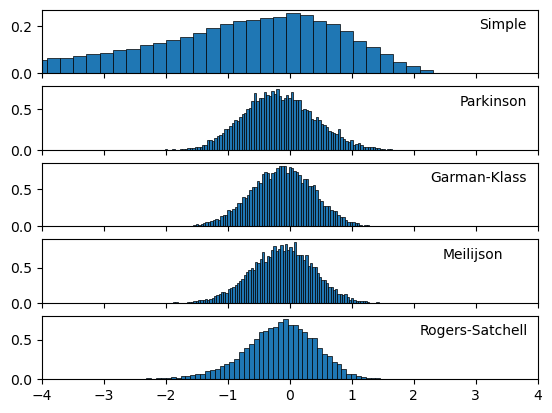

In [68]:
fig, ax = plt.subplots(5, sharex=True)
ax1, ax2, ax3, ax4, ax5 = ax

ax1.text(.93,.7, 'Simple', horizontalalignment='center', transform=ax1.transAxes);
ax1.hist(np.log(var_s), density=True, bins=100, edgecolor='black', linewidth=0.5);

ax2.text(.91,.7, 'Parkinson', horizontalalignment='center', transform=ax2.transAxes);
ax2.hist(np.log(var_pk), density=True, bins=100, edgecolor='black', linewidth=0.5);

ax3.text(.88,.7, 'Garman-Klass', horizontalalignment='center', transform=ax3.transAxes);
ax3.hist(np.log(var_gk), density=True, bins=100, edgecolor='black', linewidth=0.5);

ax4.text(.87,.7, 'Meilijson', horizontalalignment='center', transform=ax4.transAxes);
ax4.hist(np.log(var_m), density=True, bins=100, edgecolor='black', linewidth=0.5);

ax5.text(.87,.7, 'Rogers-Satchell', horizontalalignment='center', transform=ax5.transAxes);
ax5.hist(np.log(var_rs), density=True, bins=100, edgecolor='black', linewidth=0.5);

plt.setp(ax, xlim=(-4, 4))

The logarith of square returns is highly nonnormally distributed but the log of range based estimators are similar to the normal distribution.  
Given the true volatility is normalized to 1 and normality is desirable for practical reasons, an ideal distribution of log estimates should have zero mean and zero skewness.

In [73]:
df = pd.DataFrame(columns=['Mean', 'Std', 'Skewness', 'Kurtosis'])

log_s = np.log(var_s)
log_pk = np.log(var_pk)
log_gk = np.log(var_gk)
log_m = np.log(var_m)
log_rs = np.log(var_rs)

df.loc['Simple'] = [log_s.mean(), log_s.std(), moment(log_s, 3)/log_s.std()**3, kurtosis(log_s, fisher=False)]
df.loc['Park'] = [log_pk.mean(), log_pk.std(), moment(log_pk, 3)/log_pk.std()**3, kurtosis(log_pk, fisher=False)]
df.loc['GK'] = [log_gk.mean(), log_gk.std(), moment(log_gk, 3)/log_gk.std()**3, kurtosis(log_gk, fisher=False)]
df.loc['M'] = [log_m.mean(), log_m.std(), moment(log_m, 3)/log_m.std()**3, kurtosis(log_m, fisher=False)]
df.loc['RS'] = [log_rs.mean(), log_rs.std(), moment(log_rs, 3)/log_rs.std()**3, kurtosis(log_rs, fisher=False)]

print(df)

            Mean       Std  Skewness  Kurtosis
Simple -1.252729  2.179951 -1.523880  6.977300
Park   -0.176263  0.567861  0.160134  2.837364
GK     -0.134352  0.501986 -0.126950  2.937180
M      -0.132974  0.500435 -0.173088  2.960700
RS     -0.175750  0.607635 -0.832663  6.196719


The Garman-Klass and the Meilijson volatility estimators , in addition to being most efficient, have best distributional properties.

<br>

__3.  Jump Component__

Most assets are not traded continuously 24 hours a day. Therefore, opening price is not necessarily equal to the previous day closing price.  
Given we are interested in the movement throghout the whole day and not just the trading part of the day, we thus define daily returns as:  
$r_{i} = \ln{C_{i}}-\ln{C_{i-1}}$  

We therefore need to add $j^2$ to each of the estimators
where $j = \ln{O_{i}}-\ln{C_{i-1}}$ 
This unfortunately increases the variance of these estimators but it's the only way to get unbiased estimators without imposing additional assumptions.

__References__

1) Molnar, P. (2012). Properties of range-based volatility estimators. International Review of Financial Analysis, 23, 20-29.